In [1]:
    import os
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pecanpy as pp
import scipy
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import auc, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_geometric.nn as gnn
from umap import UMAP

In [2]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [3]:
np.random.seed(42)

# Dataset

In [4]:
directed = True

In [5]:
loaded_data = {}
def get_data(cell_fname, output='_elist.edg'):
    # Get graph
    if cell_type in loaded_data:
        mat = loaded_data[cell_type]
    else:
        mat = pd.read_csv('./data/training_matrices_DGL/' + f'{cell_fname}', index_col=0, sep='\t')
        loaded_data[cell_type] = mat
    genes = np.array(mat.columns)
    assert (genes == np.array(mat.index)).all()
    mat = mat.to_numpy()

    # Get edgelist
    g = pp.graph.AdjlstGraph()
    for i in range(mat.shape[0]):
        for j in range(i+1, mat.shape[0]):
            weight = float(mat[i][j])
            if weight != 0:
                g.add_edge(genes[i], genes[j], weight=weight, directed=False)
    g.save('_elist.edg')

def get_directed_data(cell_fname, output='_elist.edg'):
    # Read data
    directed = pd.read_csv(f'./data/directed/AD/{cell_fname}', sep='\t')
    
    # Turn all edge weights positive
    directed['coef'] = np.abs(directed['coef'])
    
    # Remove all zero weights
    directed = directed.iloc[np.argwhere(directed['coef'].to_numpy() != 0).flatten(), :]
    
    # Save file
    directed[['TF', 'TG', 'coef']].to_csv(output, sep='\t', header=None, index=None)

def get_labels(genes):
    # Get labels
    meta = pd.read_csv('./data/training_matrices_DGL/' + 'training_labels.txt', index_col=0, sep='\t')
    labels = meta.values[:, 0]
    labels = np.array([str(meta.loc[g]['label']) if g in meta.index else 'unknown' for g in genes])

    return labels

In [6]:
if not directed:
    cell_fnames = np.array([f for f in os.listdir('./data/training_matrices_DGL') if '.mat' in f])
else:
    cell_fnames = np.array(os.listdir('./data/directed/AD'))
cell_fname = cell_fnames[3]
cell_type = cell_fname.split('.')[0]
for ct in cell_fnames:
    ct_str = ct.split('.')[0]
    print(ct_str) if ct_str != cell_type else print(f'--{ct_str}')

Astrocyte
Endothelial
GABAergic neuron
--GABAergic PVALB interneuron
GABAergic SST interneuron
GABAergic VIP interneuron
Glutamatergic neuron
Microglia
Mural
Oligodendrocyte
OPC


Generating GABAergic PVALB interneuron graph...
Filtering data...


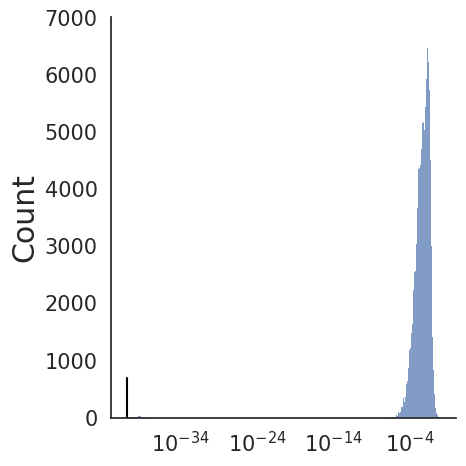

In [7]:
print(f'Generating {cell_type} graph...')
# Load data
if not directed:
    get_data(cell_fname)
else:
    get_directed_data(cell_fname)

# Plot approximate distribution
elist = pd.read_csv('_elist.edg', sep='\t', header=None)
# np.random.seed(42)
# sns.displot(np.random.choice(elist.iloc[:, 2].to_numpy().flatten(), 1000))
sns.displot(elist.iloc[:, 2].to_numpy().flatten(), log_scale=True)

# Eliminate low-value data
print(f'Filtering data...')
percentile = 0
reg_threshold = np.percentile(elist.iloc[:, 2].to_numpy().flatten(), percentile)
elist = elist.iloc[np.argwhere((elist.iloc[:, 2] >= reg_threshold).to_numpy()).flatten(), :]
elist.to_csv('_elist.edg', sep='\t', header=None, index=None)
plt.axvline(reg_threshold, ymax=.1, color='black');

# Pipeline

In [8]:
print('Reading graph...')
# Load as precomp
g = pp.pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=True)
g.read_edg('_elist.edg', weighted=True, directed=directed)
# g.preprocess_transition_probs()

Reading graph...


In [9]:
dim, num_walks, walk_length = 32, 20, 80
percentile_str = f'-{percentile}' if percentile != 0 else ''
fname = f'models/embeddings-{cell_type}-{dim}-{num_walks}-{walk_length}{percentile_str}.npy'
if os.path.exists(fname):
    print('Loading embeddings...')
    # Load embeddings
    emb_pp = np.load(fname)
else:
    print('Generating embeddings...')
    # Generate embeddings
    emb_pp = g.embed(dim=dim, num_walks=num_walks, walk_length=walk_length)
    np.save(fname, emb_pp)

# Chart connected subgraph
# surviving_nodes = [np.argwhere(genes==gn).flatten()[0] for gn in g.nodes]
genes = g.nodes
labels = get_labels(genes)

Generating embeddings...


  0%|                                                                                         | 0/39460 [00:00…

In [10]:
# Load dataset
elist = np.loadtxt('_elist.edg', dtype=str)
gene_to_index = {g: i for g, i in zip(genes, range(len(genes)))}
edge_index = np.array([[gene_to_index[f] for f in e[:2]] for e in elist]).T
edge_weight = np.array([float(e[2]) for e in elist])

# Add embeddings and labels
x = emb_pp
y = np.array([{'AD': 1, 'notAD': 0, 'unknown': 2}[l] for l in labels])

# Split data
np.random.seed(42)
unknown_idx = np.argwhere(y==2).flatten()
train_frac = .8
train_idx = np.random.choice(x.shape[0], int(train_frac * x.shape[0]), replace=False)
train_idx = np.array(list(set(train_idx) - set(unknown_idx)))
train_mask = np.zeros(x.shape[0], dtype=bool)
train_mask[train_idx] = True
val_idx = np.array(list(set(list(range(x.shape[0]))) - set(train_idx)))
val_idx = np.array(list(set(val_idx) - set(unknown_idx)))
val_mask = np.zeros(x.shape[0], dtype=bool)
val_mask[val_idx] = True

# Create dataset
dataset = tg.data.Data(
    x=torch.tensor(x).float(),
    edge_index=torch.tensor(edge_index, dtype=int),
    edge_weight=torch.tensor(edge_weight).float(),
    y=torch.tensor(y, dtype=int),
    train_mask=torch.tensor(train_mask),
    val_mask=torch.tensor(val_mask))
assert dataset.is_directed() == directed
dataset

Data(x=[1973, 32], edge_index=[2, 371887], y=[1973], edge_weight=[371887], train_mask=[1973], val_mask=[1973])

In [11]:
# Make model
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encode = gnn.Sequential('x, edge_index, edge_weight', [
            (nn.Linear(32, 64), 'x -> x'),
            # (gnn.GCNConv(32, 64), 'x, edge_index, edge_weight -> x'),
            # (nn.LeakyReLU(), 'x -> x'),
            (gnn.GCNConv(64, 32), 'x, edge_index, edge_weight -> x'),
            (nn.LeakyReLU(), 'x -> x'),
            (gnn.GCNConv(32, 16), 'x, edge_index, edge_weight -> x'),
            (nn.LeakyReLU(), 'x -> x'),
        ])
        self.decode = gnn.Sequential('x, edge_index, edge_weight', [
            (nn.Linear(16, 2), 'x -> x'),
            # (gnn.GCNConv(16, 2), 'x, edge_index, edge_weight -> x'),
            (nn.LogSoftmax(dim=-1), 'x -> x'),
        ])

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        return self.decode(self.encode(x, edge_index, edge_weight), edge_index, edge_weight)

In [12]:
torch.manual_seed(42)
np.random.seed(42)

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
fname = f'models/model-{cell_type}-{dim}-{num_walks}-{walk_length}{percentile_str}.h5'

if os.path.exists(fname) and False:  # Never load existing model
    model = torch.load(fname)
else:
    model.train()
    max_lapses = 50; min_improvement = .01
    min_loss = np.inf; lapses = 0
    for epoch in range(10_001):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if loss < min_loss - min_improvement:
            min_loss = loss.detach()
            lapses = 0
        else:
            lapses += 1
        if lapses >= max_lapses:
            print(f'Epoch {epoch}\nTrain Loss: {float(loss.detach()):.4f}\nValid Loss: {float(val_loss.detach()):.4f}')
            break
        if epoch % 100 == 0:
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
            print(f'Epoch {epoch}\nTrain Loss: {float(loss.detach()):.4f}\nValid Loss: {float(val_loss.detach()):.4f}')
    model.eval()
    torch.save(model, fname)

Epoch 0
Train Loss: 0.8291
Valid Loss: 0.8276
Epoch 100
Train Loss: 0.7031
Valid Loss: 0.6935
Epoch 200
Train Loss: 0.5552
Valid Loss: 0.5408
Epoch 300
Train Loss: 0.3929
Valid Loss: 0.3826
Epoch 400
Train Loss: 0.2738
Valid Loss: 0.2766
Epoch 500
Train Loss: 0.2011
Valid Loss: 0.2203
Epoch 600
Train Loss: 0.1715
Valid Loss: 0.2032
Epoch 648
Train Loss: 0.1653
Valid Loss: 0.2032


In [13]:
pred_raw = model(data).detach()
pred = pred_raw.argmax(dim=1)
threshold = pred_raw[train_idx, 1].flatten().quantile(1 - (sum(labels=='AD') / (sum(labels=='AD') + sum(labels=='notAD'))))

print('Evaluating performance...')
print('Train')
## Train
# Perform prediction
logits = pred_raw[:, 1][data.train_mask]
trans = {'AD': 1, 'notAD': 0, 'unknown': 2}
trans_inv = {v: k for k, v in trans.items()}
true = torch.Tensor([trans[l] for l in labels[train_idx]]).long()

# Get confusion
conf = confusion_matrix(true, 1*(logits > threshold))
# conf = confusion_matrix(true, pred)
print('T\P\t' + '\t'.join([trans_inv[i] for i in range(len(trans_inv)-1)]))
for i, row in enumerate(conf):
    print(trans_inv[i] + '\t' + '\t'.join([str(e) for e in row]))

# Other statistics
fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
print(f'AUROC:\t{auc(fpr, tpr):.4f}')
prec, rec, thresholds = precision_recall_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
print(f'AUPRC:\t{auc(rec, prec):.4f}')
correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')
print()

print('Eval')
## Eval
# Perform prediction
logits = pred_raw[:, 1][data.val_mask]
trans = {'AD': 1, 'notAD': 0, 'unknown': 2}
trans_inv = {v: k for k, v in trans.items()}
true = torch.Tensor([trans[l] for l in labels[val_idx]]).long()

# Get confusion
conf = confusion_matrix(true, 1*(logits > threshold))
# conf = confusion_matrix(true, pred)
print('T\P\t' + '\t'.join([trans_inv[i] for i in range(len(trans_inv))]))
for i, row in enumerate(conf):
    print(trans_inv[i] + '\t' + '\t'.join([str(e) for e in row]))

# Other statistics
fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
print(f'AUROC:\t{auc(fpr, tpr):.4f}')
prec, rec, thresholds = precision_recall_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
print(f'AUPRC:\t{auc(rec, prec):.4f}')
correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
acc = int(correct) / int(data.val_mask.sum())
print(f'Accuracy: {acc:.4f}')
print()

Evaluating performance...
Train
T\P	notAD	AD
notAD	485	14
AD	13	0
AUROC:	0.3928
AUPRC:	0.0192
Accuracy: 0.9746

Eval
T\P	notAD	AD	unknown
notAD	145	1
AD	4	0
AUROC:	0.6884
AUPRC:	0.0459
Accuracy: 0.9733



# Visualization

In [14]:
sns.set_palette('husl', len(np.unique(labels)))

In [15]:
name_map = {'AD': 'AD', 'notAD': 'Not AD', 'unknown': 'Unknown'}
color_map = {'AD': 'red', 'notAD': 'blue', 'unknown': 'black'}
z_map = {'AD': 2, 'notAD': 1, 'unknown': 0}
s_map = {'AD': 10., 'notAD': 1., 'unknown': .5}

In [16]:
%%capture
from matplotlib.lines import Line2D

# Legend
legend = [
    Line2D([], [], color=(1, 1, 1, 0), markerfacecolor=color_map[l], marker='o', markersize=10)
    for l in np.unique(labels)]
legend_names = [name_map[l] for l in np.unique(labels)]

# Plot legend
fig, ax = plt.subplots()
legend = ax.legend(legend, legend_names, loc='center', frameon=False, ncol=len(legend)//1)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.tight_layout()
plt.savefig('results/fig_legend.png', bbox_inches=bbox, dpi=300)

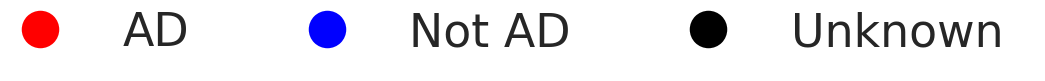

In [17]:
from IPython.display import display, Image
display( Image(filename='results/fig_legend.png', width=800) )

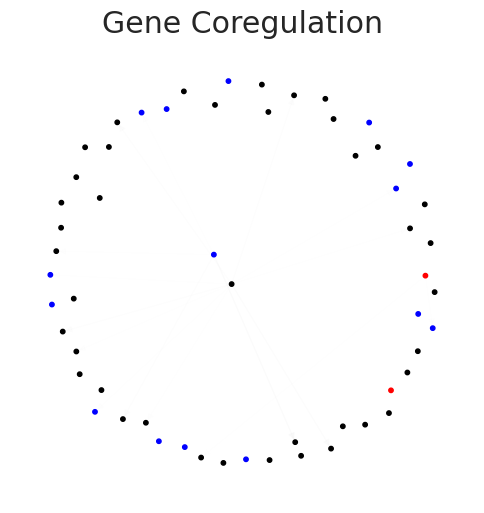

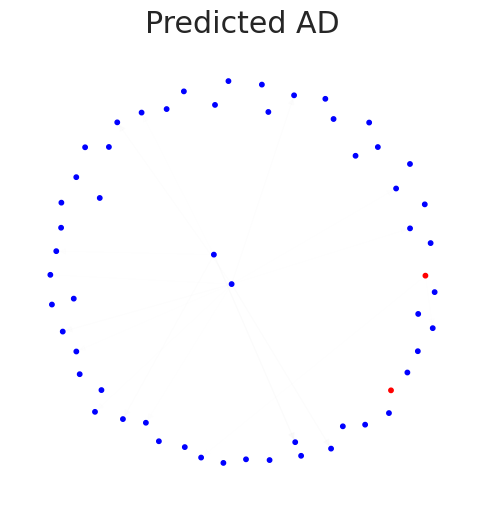

In [18]:
np.random.seed(42)
submask = torch.tensor((np.random.rand(dataset.x.shape[0]) > .97), dtype=bool)
G = tg.utils.to_networkx(dataset.subgraph(np.argwhere(submask).flatten()), node_attrs=['x'], edge_attrs=['edge_weight'], to_undirected=not directed)
edge_color = [(0, 0, 0, .1*G[u][v]['edge_weight']) for u, v in G.edges]
pos = nx.spring_layout(G, weight='edge_weight', k=.5)

# Original Data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
node_color = [color_map[trans_inv[int(v)]] for v in dataset.y[submask]]
nx.draw(
    G,
    node_color=node_color,
    edge_color=edge_color,
    node_size=10,
    pos=pos,
)
plt.title('Gene Coregulation')
plt.savefig('results/fig_data.png', dpi=300)

# Computed Data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# pred = model(dataset).detach().argmax(dim=1)
threshold = pred_raw[train_idx, 1].flatten().quantile(1 - (sum(labels=='AD') / (sum(labels=='AD') + sum(labels=='notAD'))))
pred = 1*(model(dataset).detach()[:, 1] > threshold)
# Show known
node_color = [color_map[trans_inv[int(v)]] if v != 2 else color_map[trans_inv[int(w)]] for v, w in zip(dataset.y[submask], pred[submask])]
# Do not show known
# node_color = [color_map[trans_inv[int(v)]] for v in pred[submask]]
nx.draw(
    G,
    node_color=node_color,
    edge_color=edge_color,
    node_size=10,
    pos=pos,
)
plt.title('Predicted AD')
plt.savefig('results/fig_prediction.png', dpi=300)

In [19]:
def display_umap(transformed_data, labels):
    for l in np.unique(labels):
        plt.scatter(
            *transformed_data[labels==l, :].T,
            c=color_map[l],
            zorder=z_map[l],
            s=s_map[l],
            label=l)
    sns.despine(left=True, bottom=True)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

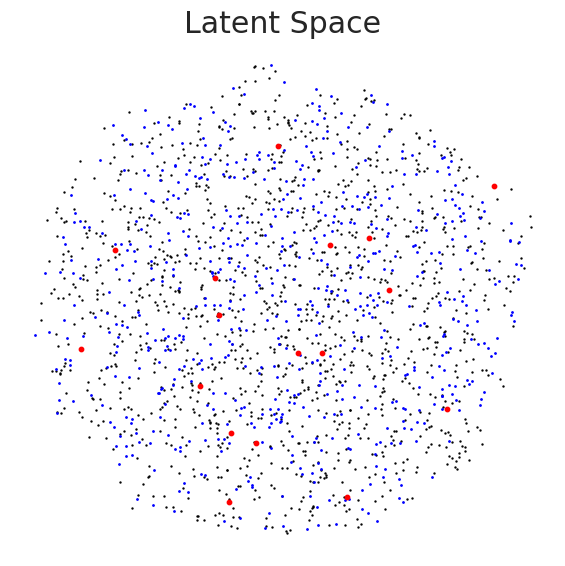

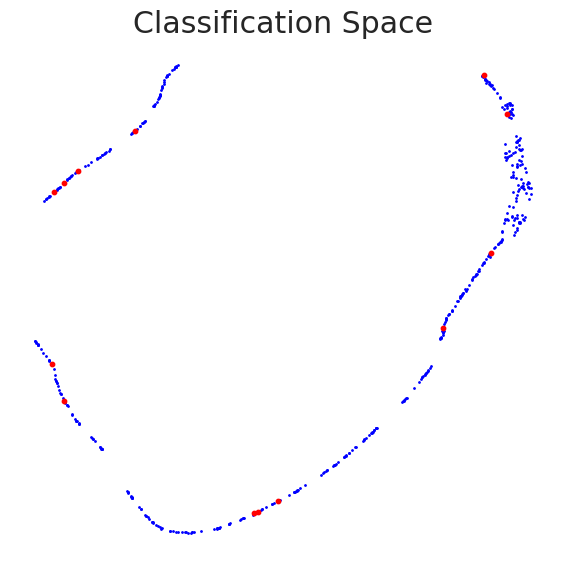

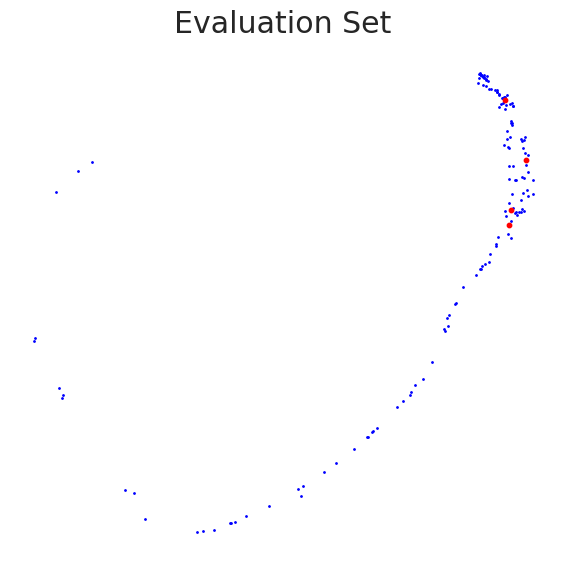

In [20]:
# Embeddings
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
transformed_data = UMAP(n_components=2, random_state=42).fit_transform(emb_pp)
display_umap(transformed_data, labels)
plt.title('Latent Space')
plt.tight_layout()
plt.savefig('results/fig_latent.png', dpi=300)

# Umap for training-eval transform
umap = UMAP(n_components=2, random_state=42)
data = dataset.subgraph(np.argwhere(dataset.train_mask).flatten())
umap.fit(model.encode(data.x, data.edge_index, data.edge_weight).detach().numpy())

# Training plot
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
data = dataset.subgraph(np.argwhere(dataset.train_mask).flatten())
transformed_data = umap.transform(model.encode(data.x, data.edge_index, data.edge_weight).detach().numpy())
display_umap(transformed_data, labels[train_idx])
plt.title('Classification Space')
plt.tight_layout()
plt.savefig('results/fig_classification.png', dpi=300)
xlim, ylim = plt.xlim(), plt.ylim()

# Evaluation plot
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
data = dataset.subgraph(np.argwhere(dataset.val_mask).flatten())
transformed_data = umap.transform(model.encode(data.x, data.edge_index, data.edge_weight).detach().numpy())
display_umap(transformed_data, labels[val_idx])
# plt.plot(np.array(xlim), .4*np.array(xlim)+0, '-', color='red', linewidth=2)
plt.xlim(xlim)
plt.ylim(ylim)
plt.title('Evaluation Set')
plt.tight_layout()
plt.savefig('results/fig_classification_eval.png', dpi=300)